In [48]:
import pandas as pd
import psycopg2
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from gensim.models.doc2vec import Doc2Vec
from faiss import read_index
import pickle
from gensim.utils import simple_preprocess
import numpy as np
from psycopg2.extras import execute_values
from xgboost import XGBRanker
from operator import itemgetter
import matplotlib.pyplot as plt
from multiprocessing import Pool

plt.rcParams['text.usetex'] = False
# plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams.update({'font.size': 18})
plt.rcParams.update({'figure.figsize': [10, 6]})

# Divide countries

## Get hdi

In [2]:
# https://data.humdata.org/dataset/human-development-index-hdi
# https://hdr.undp.org/data-center/documentation-and-downloads

In [3]:
hdi_df = pd.read_excel("HDR21-22_Statistical_Annex_HDI_Table.xlsx", header=4)
hdi_df = hdi_df.rename(
    columns={"Unnamed: 1": "country", "Human Development Index (HDI) ": "value"}
)
hdi_df = hdi_df[["country", "value"]].dropna()[1:]
hdi_df["country"] = hdi_df["country"].str.lower()
hdi_df["value"] = pd.to_numeric(hdi_df["value"], errors="coerce")
hdi_df = hdi_df.set_index("country")

In [4]:
hdi_df.head(5)

,value
country,
switzerland,0.962
norway,0.961
iceland,0.959
"hong kong, china (sar)",0.952
australia,0.951


In [5]:
hdi_df[hdi_df["value"].isna()]

,value
country,
korea (democratic people's rep. of),NaN
monaco,NaN
nauru,NaN
somalia,NaN


In [6]:
hdi_df = hdi_df.dropna()

## Get user data

In [7]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="54320",
    database="stack_overflow",
)

In [8]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select id, country
                            from users
                            where country is not NULL
                            """
        )
        users = pd.DataFrame(cursor.fetchall(), columns=["user_id", "country"])
print(len(users))
users.head()

3941484


,user_id,country
0,22545,New Zealand
1,22621,Norway
2,22656,United Kingdom
3,6050,United Kingdom
4,519,United States


In [9]:
# missing_countries = users[users["value"].isna()]["country"].unique()
# [(missing_country, in_df_name[0])
# for missing_country in missing_countries
# if (in_df_name:=hdi_df.index[hdi_df.index.str.contains(missing_country)].values).size>0]

# faroe islands HDI (2008)	0.950
# falkland islands HDI (2010)	0.874
# greenland HDI (2010)	0.786
# curacao HDI (2012)	0.811
# cayman islands HDI (2013)	0.984
# puerto rico HDI (2015)	0.845
# kosovo HDI (2016)	0.742
# guam HDI (2017) 0.901
# aland islands HDI (2017)	0.900
# gibraltar HDI (2018)	0.961
# macao HDI (2019) 0.922
# taiwan HDI (2021)	0.926

countries_to_replace = [
    ("russia", "russian federation"),
    ("tanzania", "tanzania (united republic of)"),
    ("hong kong", "hong kong, china (sar)"),
    ("moldova", "moldova (republic of)"),
    ("iran", "iran (islamic republic of)"),
    ("i̇ran", "iran (islamic republic of)"),
    ("syria", "syrian arab republic"),
    ("venezuela", "venezuela (bolivarian republic of)"),
    ("bolivia", "bolivia (plurinational state of)"),
    ("brunei", "brunei darussalam"),
    ("micronesia", "micronesia (federated states of)"),
    ("eswatini", "eswatini (kingdom of)"),
    ("turkey", "türkiye"),
    ("vietnam", "viet nam"),
    ("south korea", "korea (republic of)"),
    ("democratic republic of the congo", "congo (democratic republic of the)"),
    ("palestinian territory", "palestine, state of"),
    ("timor leste", "timor-leste"),
    ("ivory coast", "côte d'ivoire"),
    ("laos", "lao people's democratic republic"),
    ("republic of the congo", "congo"),
    ("i̇taly", "italy"),
    ("i̇raq", "iraq"),
]
users["country"] = users["country"].str.lower()
for original_country, replace_country in countries_to_replace:
    users["country"] = users["country"].str.replace(original_country, replace_country)

In [10]:
users = users.join(hdi_df, on="country")
users.head()

,user_id,country,value
0,22545,new zealand,0.937
1,22621,norway,0.961
2,22656,united kingdom,0.929
3,6050,united kingdom,0.929
4,519,united states,0.921


In [11]:
users[users["value"].isna()]["country"].unique()

array(['error', 'taiwan', 'cayman islands', 'puerto rico', 'jersey',
       'somalia', 'macao', 'kosovo', 'isle of man', 'bermuda',
       'saint martin', 'guernsey', 'reunion', 'new caledonia',
       'guadeloupe', 'greenland', 'american samoa', 'monaco',
       'french southern territories', 'aruba', 'curacao', 'guam',
       'faroe islands', 'anguilla', 'gibraltar', 'aland islands',
       'saint helena', 'cook islands', 'french polynesia', 'martinique',
       'christmas island', 'norfolk island', 'svalbard and jan mayen',
       'sint maarten', 'north korea',
       'bonaire, saint eustatius and saba ', 'turks and caicos islands',
       'northern mariana islands', 'united states minor outlying islands',
       'pitcairn', 'nauru', 'montserrat', 'u.s. virgin islands',
       'western sahara', 'south georgia and the south sandwich islands',
       'french guiana', 'niue', 'mayotte', 'british virgin islands',
       'wallis and futuna', 'falkland islands',
       'saint pierre and m

In [12]:
users = users[~users["value"].isna()]
len(users)

3872918

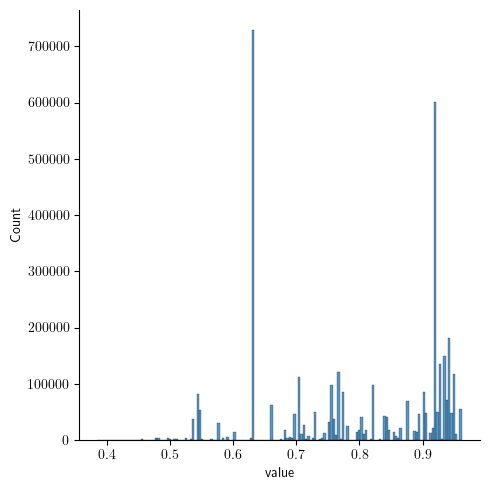

In [13]:
sns.displot(users, x="value")

In [14]:
users[users["country"] == "india"]["country"].count(), hdi_df.loc["india"]["value"]

(719511, 0.633)

In [15]:
users[users["country"] == "united states"]["country"].count(), hdi_df.loc[
    "united states"
]["value"]

(574402, 0.921)

## Divide users

In [16]:
HDI_THRESHOLD = 0.92
users["developed_country"] = (users["value"] > HDI_THRESHOLD).astype(int)
users["developed_country"].mean()

0.3602363902359926

In [62]:
hdi_for_plot = pd.concat([hdi_df[hdi_df["value"]>0.92].sort_values(by=["value"], ascending=False).tail(6),
           hdi_df[hdi_df["value"]<=0.92].sort_values(by=["value"], ascending=False).head(6)]).reset_index()

In [95]:
hdi_for_plot["country"] = hdi_for_plot["country"].str.title()
hdi_for_plot

,country,value
0,Liechtenstein,0.935
1,Luxembourg,0.930
2,United Kingdom,0.929
3,Japan,0.925
4,Korea (Republic Of),0.925
5,United States,0.921
6,Israel,0.919
7,Malta,0.918
8,Slovenia,0.918
9,Austria,0.916


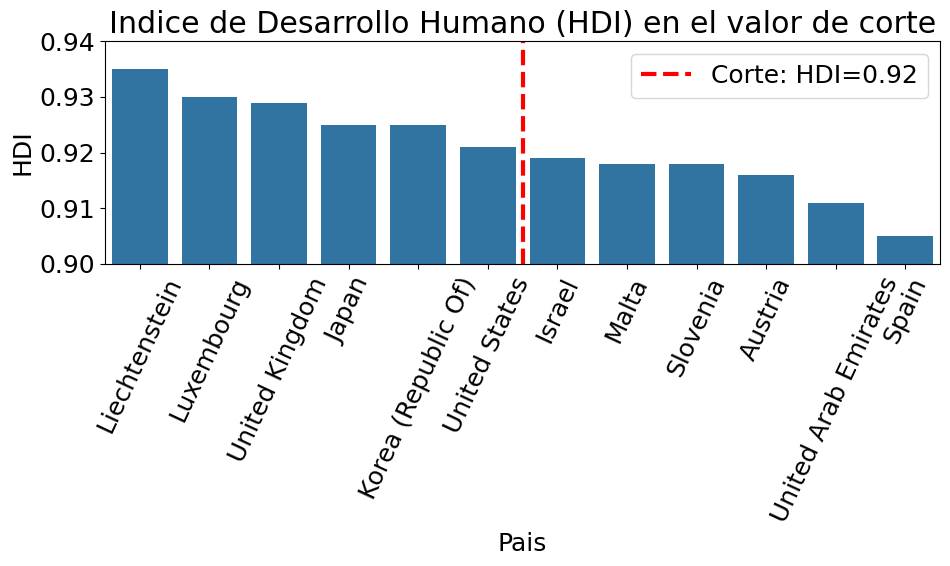

In [102]:

g = sns.barplot(hdi_for_plot, x="country", y="value", color="tab:blue")
g.set_ylim([0.9, 0.94])
plt.xticks(rotation=65)
plt.title("Indice de Desarrollo Humano (HDI) en el valor de corte")
plt.xlabel("Pais")
plt.ylabel("HDI")
plt.axvline(x=5.5, color="red", label="Corte: HDI=0.92", linewidth=3, linestyle="--")
plt.legend()
plt.tight_layout()
plt.savefig("hdis.png")

# Create dataset

In [17]:
question_embeddings_model = Doc2Vec.load("../text_model/python.doc")
question_transformer_model = tf.keras.models.load_model(
    "../../scripts/text_model/question_transformer_model"
)
index = read_index("../../scripts/text_model/users_imp.index")

In [18]:
with open("../../scripts/text_model/user_embeddings.pickle", "rb") as f:
    user_embedding, user_encoder = pickle.load(f)

In [19]:
MIN_ANSWERS = 3
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join posts_19 a on a.parent_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.creation_date >= '2022-01-01'
        and t.tag_name = 'python'
        group by p.id
        HAVING count(*) > {MIN_ANSWERS}
        limit 30000"""
        )
        posts = cursor.fetchall()

In [20]:
posts_vectors = []
posts_ids = []
for p_id, title, body in posts:
    posts_ids.append(p_id)
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    posts_vectors.append(
        question_embeddings_model.infer_vector(simple_preprocess(post_text))
    )

In [21]:
posts_vectors = np.array(posts_vectors)
posts_vectors.shape

(3973, 50)

In [22]:
questions_transformed = question_transformer_model.predict(posts_vectors)
questions_transformed.shape

125/125 [==============================] - 0s 790us/step


(3973, 10)

In [23]:
qid2emb = {pid: emb for pid, emb in zip(posts_ids, questions_transformed)}

In [24]:
distances, similar_questions = index.search(questions_transformed, 10000)
features_df = pd.DataFrame(
    list(zip(posts_ids, similar_questions)), columns=["q_id", "u_id"]
).explode("u_id")
features_df["u_id"] = features_df["u_id"].astype(int)

In [25]:
batch_size = 1000000

results = []
with connection:
    for batch_idx in range(len(features_df) // batch_size):
        with connection.cursor() as cursor:
            execute_values(
                cursor,
                """select q_id, u_id, q_a.score
                                    FROM (VALUES %s) AS base_questions (q_id, u_id)
                                    JOIN posts_19 q_a ON q_a.parent_id = q_id
                                    WHERE q_a.owner_user_id=u_id""",
                features_df[batch_idx * batch_size : (batch_idx + 1) * batch_size][
                    ["q_id", "u_id"]
                ].values.tolist(),
                page_size=batch_size,
            )
            results.extend(cursor.fetchall())
dataset = pd.DataFrame(results, columns=["q_id", "u_id", "score"])

In [26]:
dataset.sort_values(by=["q_id"], inplace=True)
print(len(dataset))
dataset.head()

6411


,q_id,u_id,score
46,70547027,901925,4
66,70547027,2988730,2
143,70547027,2988730,0
93,70547281,786593,0
53,70547281,14531062,0


In [27]:
after_fair_df = pd.read_csv("after_fair_data.csv")
after_fair_df.head()

,q_id,u_id,developed_country,idx,pscore
0,70547027,100297,1,0,2.340971
1,70547027,7574575,0,1,2.266549
2,70547027,11923558,0,2,2.071728
3,70547027,1624921,1,3,2.033441
4,70547027,325565,1,4,1.930067


In [28]:
after_fair_df.idx.value_counts()

0     3973
63    3973
73    3973
72    3973
71    3973
      ... 
30    3973
29    3973
28    3973
27    3973
99    3973
Name: idx, Length: 100, dtype: int64

In [29]:
fair_dataset = after_fair_df.merge(dataset, on=["q_id", "u_id"], how="left")
fair_dataset["is_answer"] = (~fair_dataset["score"].isna()).astype(int)
fair_dataset.head()

,q_id,u_id,developed_country,idx,pscore,score,is_answer
0,70547027,100297,1,0,2.340971,NaN,0
1,70547027,7574575,0,1,2.266549,NaN,0
2,70547027,11923558,0,2,2.071728,NaN,0
3,70547027,1624921,1,3,2.033441,NaN,0
4,70547027,325565,1,4,1.930067,NaN,0


In [30]:
fair_dataset["is_answer"].mean()

0.0011024414799899321

In [31]:
top_k = list(range(1, 100))


def calculate_top_k_p(k):
    top_df = fair_dataset.groupby("q_id", group_keys=False)[
        ["developed_country", "is_answer", "q_id"]
    ].apply(lambda x: x.head(k))
    return (
        top_df[top_df["developed_country"] == 1]["is_answer"].mean(),
        top_df[top_df["developed_country"] == 0]["is_answer"].mean(),
    )


with Pool(8) as p:
    p_is_answer_cond = p.map(calculate_top_k_p, top_k)
p_is_answer_dev, p_is_answer_no_dev = zip(*p_is_answer_cond)

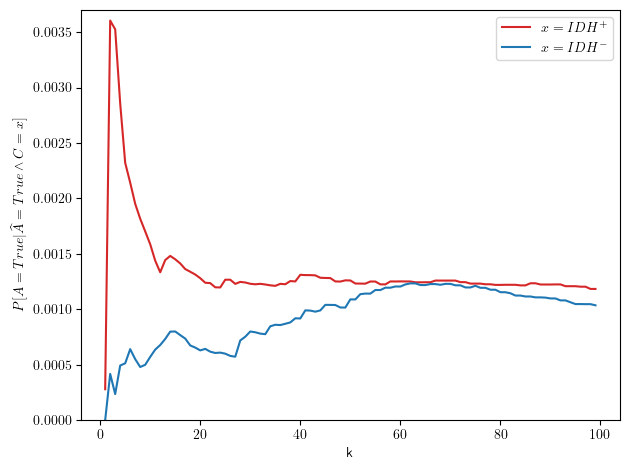

In [32]:
fig, ax1 = plt.subplots()

color = "tab:red"
ax1.set_xlabel("k")
ax1.set_ylabel("$P[A=True|\widehat{A}=True \land C=x]$")
ax1.plot(top_k, p_is_answer_dev, color=color, label="$x=IDH^+$")
ax1.plot(top_k, p_is_answer_no_dev, color="tab:blue", label="$x=IDH^-$")
ax1.set_ylim([0, 0.0037])
ax1.legend()

fig.tight_layout()
fig.savefig("prec_mean_after.pdf")
plt.show()

In [33]:
p_is_answer_dev[:5], p_is_answer_no_dev[:5]

((0.00027878449958182325,
  0.003604902667627974,
  0.003525724732306085,
  0.002857142857142857,
  0.002321147309956064),
 (0.0,
  0.0004170141784820684,
  0.0002346866932644919,
  0.0004924491135915955,
  0.0005126890540886952))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


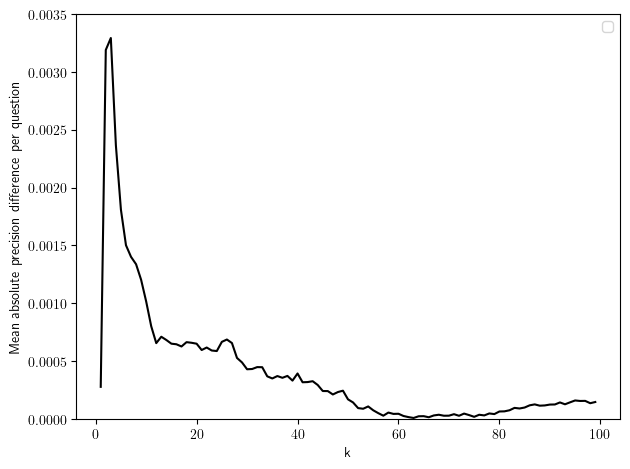

In [34]:
fig, ax1 = plt.subplots()

mean_prec_difference = [np.absolute(k_dev_mean_prec - k_no_dev_mean_prec)
                             for k_dev_mean_prec, k_no_dev_mean_prec
                             in zip(p_is_answer_dev, p_is_answer_no_dev)]
color = "black"
ax1.set_xlabel("k")
ax1.set_ylabel("Mean absolute precision difference per question")
ax1.plot(top_k, mean_prec_difference, color=color)
ax1.set_ylim(0, 0.0035)

fig.savefig("prec_difference_after.pdf")
fig.tight_layout()
ax1.legend()

In [37]:
top_k = list(range(1, 100))

def calculate_top_k_p_all(k):
    top_df = fair_dataset.groupby("q_id", group_keys=False)[
        ["developed_country", "is_answer", "q_id"]
    ].apply(lambda x: x.head(k))
    return top_df["is_answer"].mean()


with Pool(8) as p:
    p_is_answer_all = p.map(calculate_top_k_p_all, top_k)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


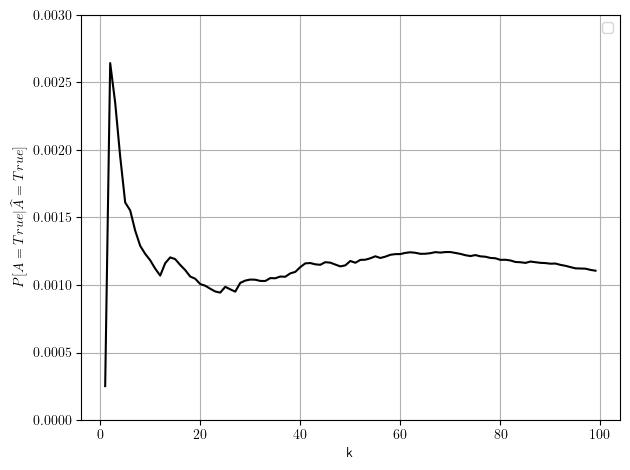

In [41]:
fig, ax1 = plt.subplots()

color = "black"
ax1.set_xlabel("k")
ax1.set_ylabel("$P[A=True|\widehat{A}=True]$")
ax1.plot(top_k, p_is_answer_all, color=color)
ax1.set_ylim([0, 0.003])
ax1.legend()
ax1.grid()

fig.tight_layout()
fig.savefig("prec_mean_after_all.pdf")
plt.show()